In [1]:
%load_ext autoreload
%autoreload 2

# Images Semantic Segmentation

In [2]:
import sys

import PIL
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('../..')
from batchflow import B, V, F, R, P, W
from batchflow.opensets import PascalSegmentation
from batchflow.models.torch import TorchModel, UNet
from batchflow.models.metrics import ClassificationMetrics

from utils import segmentation_plot

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

## Load data. May take some time.

In [3]:
data = PascalSegmentation(bar=True)

In [4]:
print('Images in train: {}'.format(len(data.train)))
print('Images in test: {}'.format(len(data.test)))

Images in train: 1464
Images in test: 1449


## Take a look at the data.

In [5]:
gen = (i for i in range(1000))

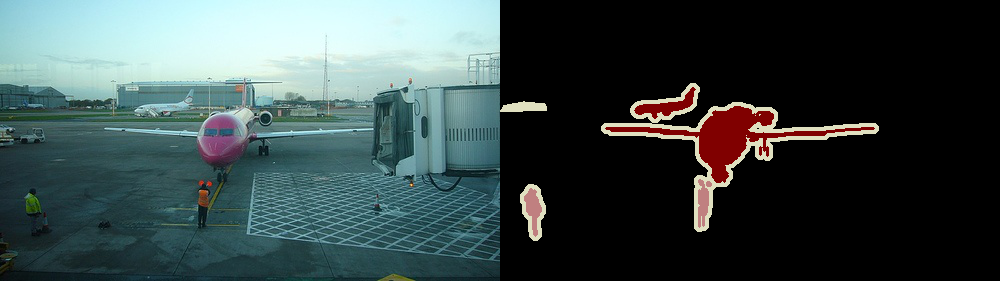

In [6]:
i = next(gen)
segmentation_plot((data.train.images[i]), data.train.labels[i])

## Set the model!

In [7]:
NUM_CLASSES = 22
model_config = {
                'body/encoder/num_stages': 4,
                'body/decoder/blocks/filters': [128, 64, 64, 32],
                'body/encoder/blocks/filters': [32, 64, 64, 128],
                'body/embedding/filters': 128,
                'head': dict(layout='c', filters=NUM_CLASSES, kernel_size=1),
    
                'optimizer': ('Adam', {'lr': 0.001}),
                'device': 'gpu:5',
                'loss': 'ce'
            }

In [8]:
def process_mask(x):
    x = np.squeeze(x)
    np.place(x, x==255, 21)
    return x

## Define training pipeline

In [9]:
BATCH_SIZE = 32
N_EPOCHS = 10

In [10]:
size = (160, 160)
pipeline = (data.train.p
                 .init_model('dynamic', UNet, 'segm', config=model_config)   #initialize model
                 .resize(size=size, src='images', dst='images')              # resize image
                 .resize(size=size, src='labels', dst='labels')              # resize mask
                 .init_variable('loss', [])                                  # save the loss here
                 .to_array(channels='first')                                 # convert the image from PIL to np.array with channels  as first dimension
                 .to_array(channels='first', src='labels', dst='labels')     # same for mask
                 .apply_transform_all(src='labels', dst='labels', func=process_mask)  #  replace 255 ->>> 21
                 .train_model('segm', B('images'), B('labels'), fetches='loss', save_to=V('loss', mode='a')) # train the model
                 .run_later(BATCH_SIZE, n_epochs=N_EPOCHS, drop_last=True, shuffle=42, bar=True)                
            )

In [11]:
pipeline.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

Loss is: 1.101051: 100%|██████████| 450/450 [02:36<00:00,  2.88it/s] 


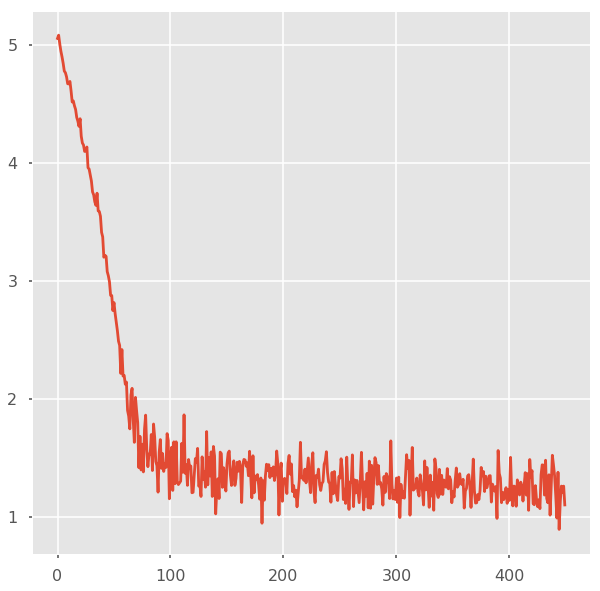

In [12]:
loss = pipeline.v('loss')
plt.figure(figsize=(10, 10))
plt.plot(loss)

## Set the test pipeline

In [13]:
test_pipeline = (data.test.p
                    .import_model('segm', pipeline)
                    .resize(size=size, src='images', dst='images')
                    .resize(size=size, src='labels', dst='labels')
                    .init_variable('predictions')
                    .to_array(channels='first')
                    .to_array(channels='first', src='labels', dst='labels')
                    .apply_transform_all(src='labels', dst='labels', func=process_mask)
                    .predict_model('segm', B('images'), fetches='predictions', save_to=B('predictions'))
                )                 

In [14]:
batch = test_pipeline.next_batch(5, shuffle=True)

In [15]:
from batchflow.models.metrics import SegmentationMetricsByPixels

## Evaluate metrics

In [16]:
metrics = SegmentationMetricsByPixels(batch.labels, batch.predictions, axis=-1, 
                                      fmt='logits', num_classes=22)

In [17]:
metrics.evaluate(['iou', 'accuracy'])

{'accuracy': 0.038859375, 'iou': 0.01888716694831769}

## Plot predictions

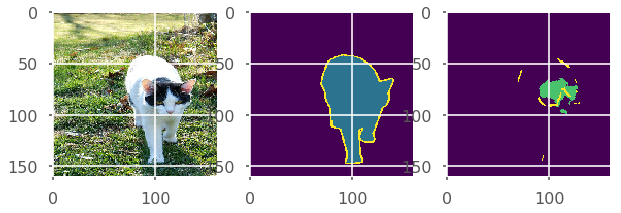

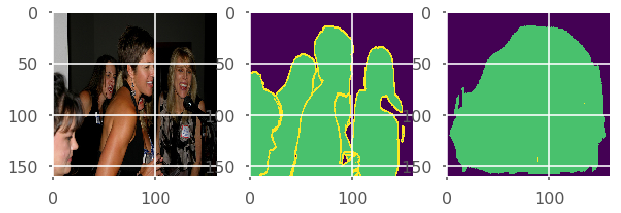

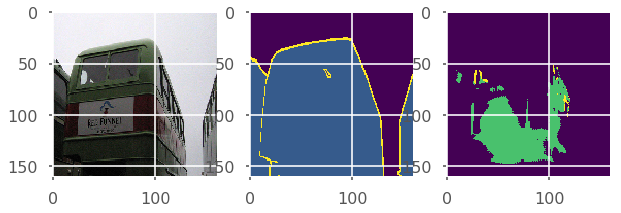

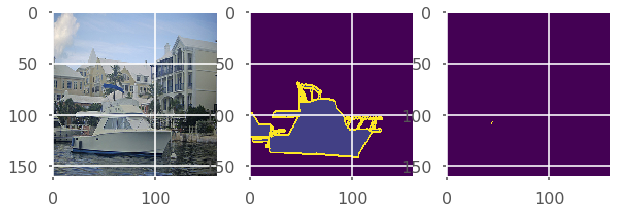

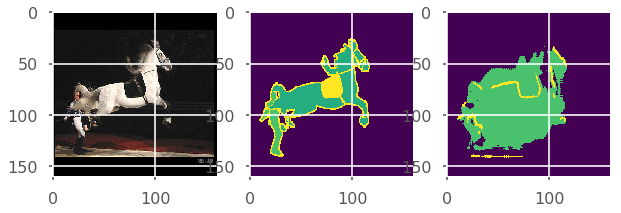

In [18]:
for i in range(len(batch)):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    image = np.moveaxis(batch.images[i], 0, -1)
    ax[0].imshow(image)
    ax[1].imshow(batch.labels[i])
    ax[2].imshow(np.argmax(batch.predictions[i], axis=0))